# Field inference from multiple uniformly magnetized prisms

This notebook demonstrates that it is possible to learn analytical forms like the demagnetizing field of a uniformly magnetized prism with good accuracy with a physically credible network and desirable scaling behaviour. In this demonstration, we want to model the potential/field from multiple fixed sources at arbitrary field points, and to do so while running over the sources and inference points separately; i.e. O(M + N) and not O(M * N).

We suppose this to be possible because of the principle of superposition for potentials / fields, and our implementation separately the input of magnetic sources (the 'priming' network) from the inference ('main' network). In particular, we try learning a hypernetwork where the role of the priming network is to output the weights for the main network. We will use jax, equinox and optax to develop a model combining neural and analytical (autodiff) components.

In [1]:
import optax
from hypermagnetics import plots
from hypermagnetics.sources import configure
from hypermagnetics.models.hyper_fourier import FourierModel
from hypermagnetics.measures import loss, accuracy
from hypermagnetics.runner import fit
import matplotlib.pyplot as plt
import scienceplots  # noqa

plt.style.use(["science", "ieee"])

## I. Target definition and data generation

We expect the neural components of the model to learn transcendental functions. The demagnetising field field at $\mathbf{r}$ from a collection of uniformly magnetized prisms with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as:

$$
\begin{align}
    \begin{bmatrix} F(x,y,z) \\ F(y,z,x) \\F(z,x,y) \\ \end{bmatrix}
    &= 
    \begin{bmatrix}
    \arctan\left(\frac{yz}{xr}\right) & -\log(z+r) & -\log(y+r) \\
    -\log(z+r) & \arctan\left(\frac{zx}{yr}\right) & -\log(x+r) \\
    -\log(y+r) & -\log(x+r) & \arctan\left(\frac{xy}{zr}\right) \\
    \end{bmatrix}
    \begin{bmatrix} x \\ y \\ z \end{bmatrix}& \\
    &\equiv \mathbb{F}\cdot{\mathbf{r}}&&
\end{align}
$$.

In two dimensions (infintely thin uniformly magnetised plate), this simplifies to:
$$
\begin{align}
    \begin{bmatrix} F(x,y) \\ F(y,x) \\ \end{bmatrix}
    &=
    \begin{bmatrix}
    -\log(y+r) \cdot x \\
    -\log(x+r) \cdot y \\
    \end{bmatrix}& \\
    &\equiv \mathbb{F}\cdot{\mathbf{r}}&&
\end{align}
$$.

$$
\phi = - \frac{1}{2 \pi} \mathbf{m}\cdot\left.\left(\mathbb{F}\cdot\mathbf{r}\right)\right|^{\{+a,+b\}}_{\{-a,-b\}},
$$


We generate random samples to serve as the training data, precomputing the target potential values. Using a fixed training set helps with the stability of training, but we refresh the validation set each time its accuracy computation is needed. First, we describe the collection of sources.

In [2]:
source_config = {
    "shape": "prism",
    "n_samples": 100,
    "lim": 3,
    "res": 96,
    "dim": 2,
}
train = configure(**source_config, n_sources=1, seed=100)
val = configure(**source_config, n_sources=4, seed=101)
# plots(train, idx=1)

In [3]:
model = FourierModel(64, seed=42)
print(loss(model, train), accuracy(model, train))

11.278293 159.54135


In [4]:
schedule = [
    # {"optim": optax.adam, "epochs": 10000, "params": {"learning_rate": 1e-2}},
    {"optim": optax.adam, "epochs": 10000, "params": {"learning_rate": 1e-3}},
    # {"optim": optax.adam, "epochs": 50000, "params": {"learning_rate": 1e-4}},
    # {"optim": optax.adam, "epochs": 50000, "params": {"learning_rate": 1e-5}},
]

for trainer_config in schedule:
    optim = trainer_config["optim"](**trainer_config["params"])
    model = fit(trainer_config, optim, model, train, val, every=100)
    print(model.k)

2024-06-11 18:43:10.984330: W external/xla/xla/service/hlo_rematerialization.cc:2946] Can't reduce memory use below 5.43GiB (5833926542 bytes) by rematerialization; only reduced to 9.02GiB (9682353680 bytes), down from 9.02GiB (9682354416 bytes) originally


{'epoch': 0, 'train_loss': 11.278292655944824, 'train_err': 172922.34375, 'test_err': 219783.234375}
[0.0000000e+00 1.2865410e-03 1.4729002e-03 1.6862549e-03 1.9305138e-03
 2.2101554e-03 2.5303029e-03 2.8968260e-03 3.3164395e-03 3.7968352e-03
 4.3468201e-03 4.9764696e-03 5.6973286e-03 6.5226029e-03 7.4674245e-03
 8.5491072e-03 9.7874701e-03 1.1205216e-02 1.2828320e-02 1.4686547e-02
 1.6813941e-02 1.9249493e-02 2.2037838e-02 2.5230095e-02 2.8884746e-02
 3.3068795e-02 3.7858915e-02 4.3342888e-02 4.9621254e-02 5.6809053e-02
 6.5038025e-02 7.4458987e-02 8.5244611e-02 9.7592533e-02 1.1172912e-01
 1.2791342e-01 1.4644212e-01 1.6765469e-01 1.9193998e-01 2.1974319e-01
 2.5157365e-01 2.8801486e-01 3.2973465e-01 3.7749770e-01 4.3217957e-01
 4.9478209e-01 5.6645286e-01 6.4850551e-01 7.4244350e-01 8.4998870e-01
 9.7311211e-01 1.1140703e+00 1.2754474e+00 1.4601996e+00 1.6717139e+00
 1.9138676e+00 2.1910970e+00 2.5084841e+00 2.8718455e+00 3.2878413e+00
 3.7640967e+00 4.3093376e+00 4.9335580e+00 5.64

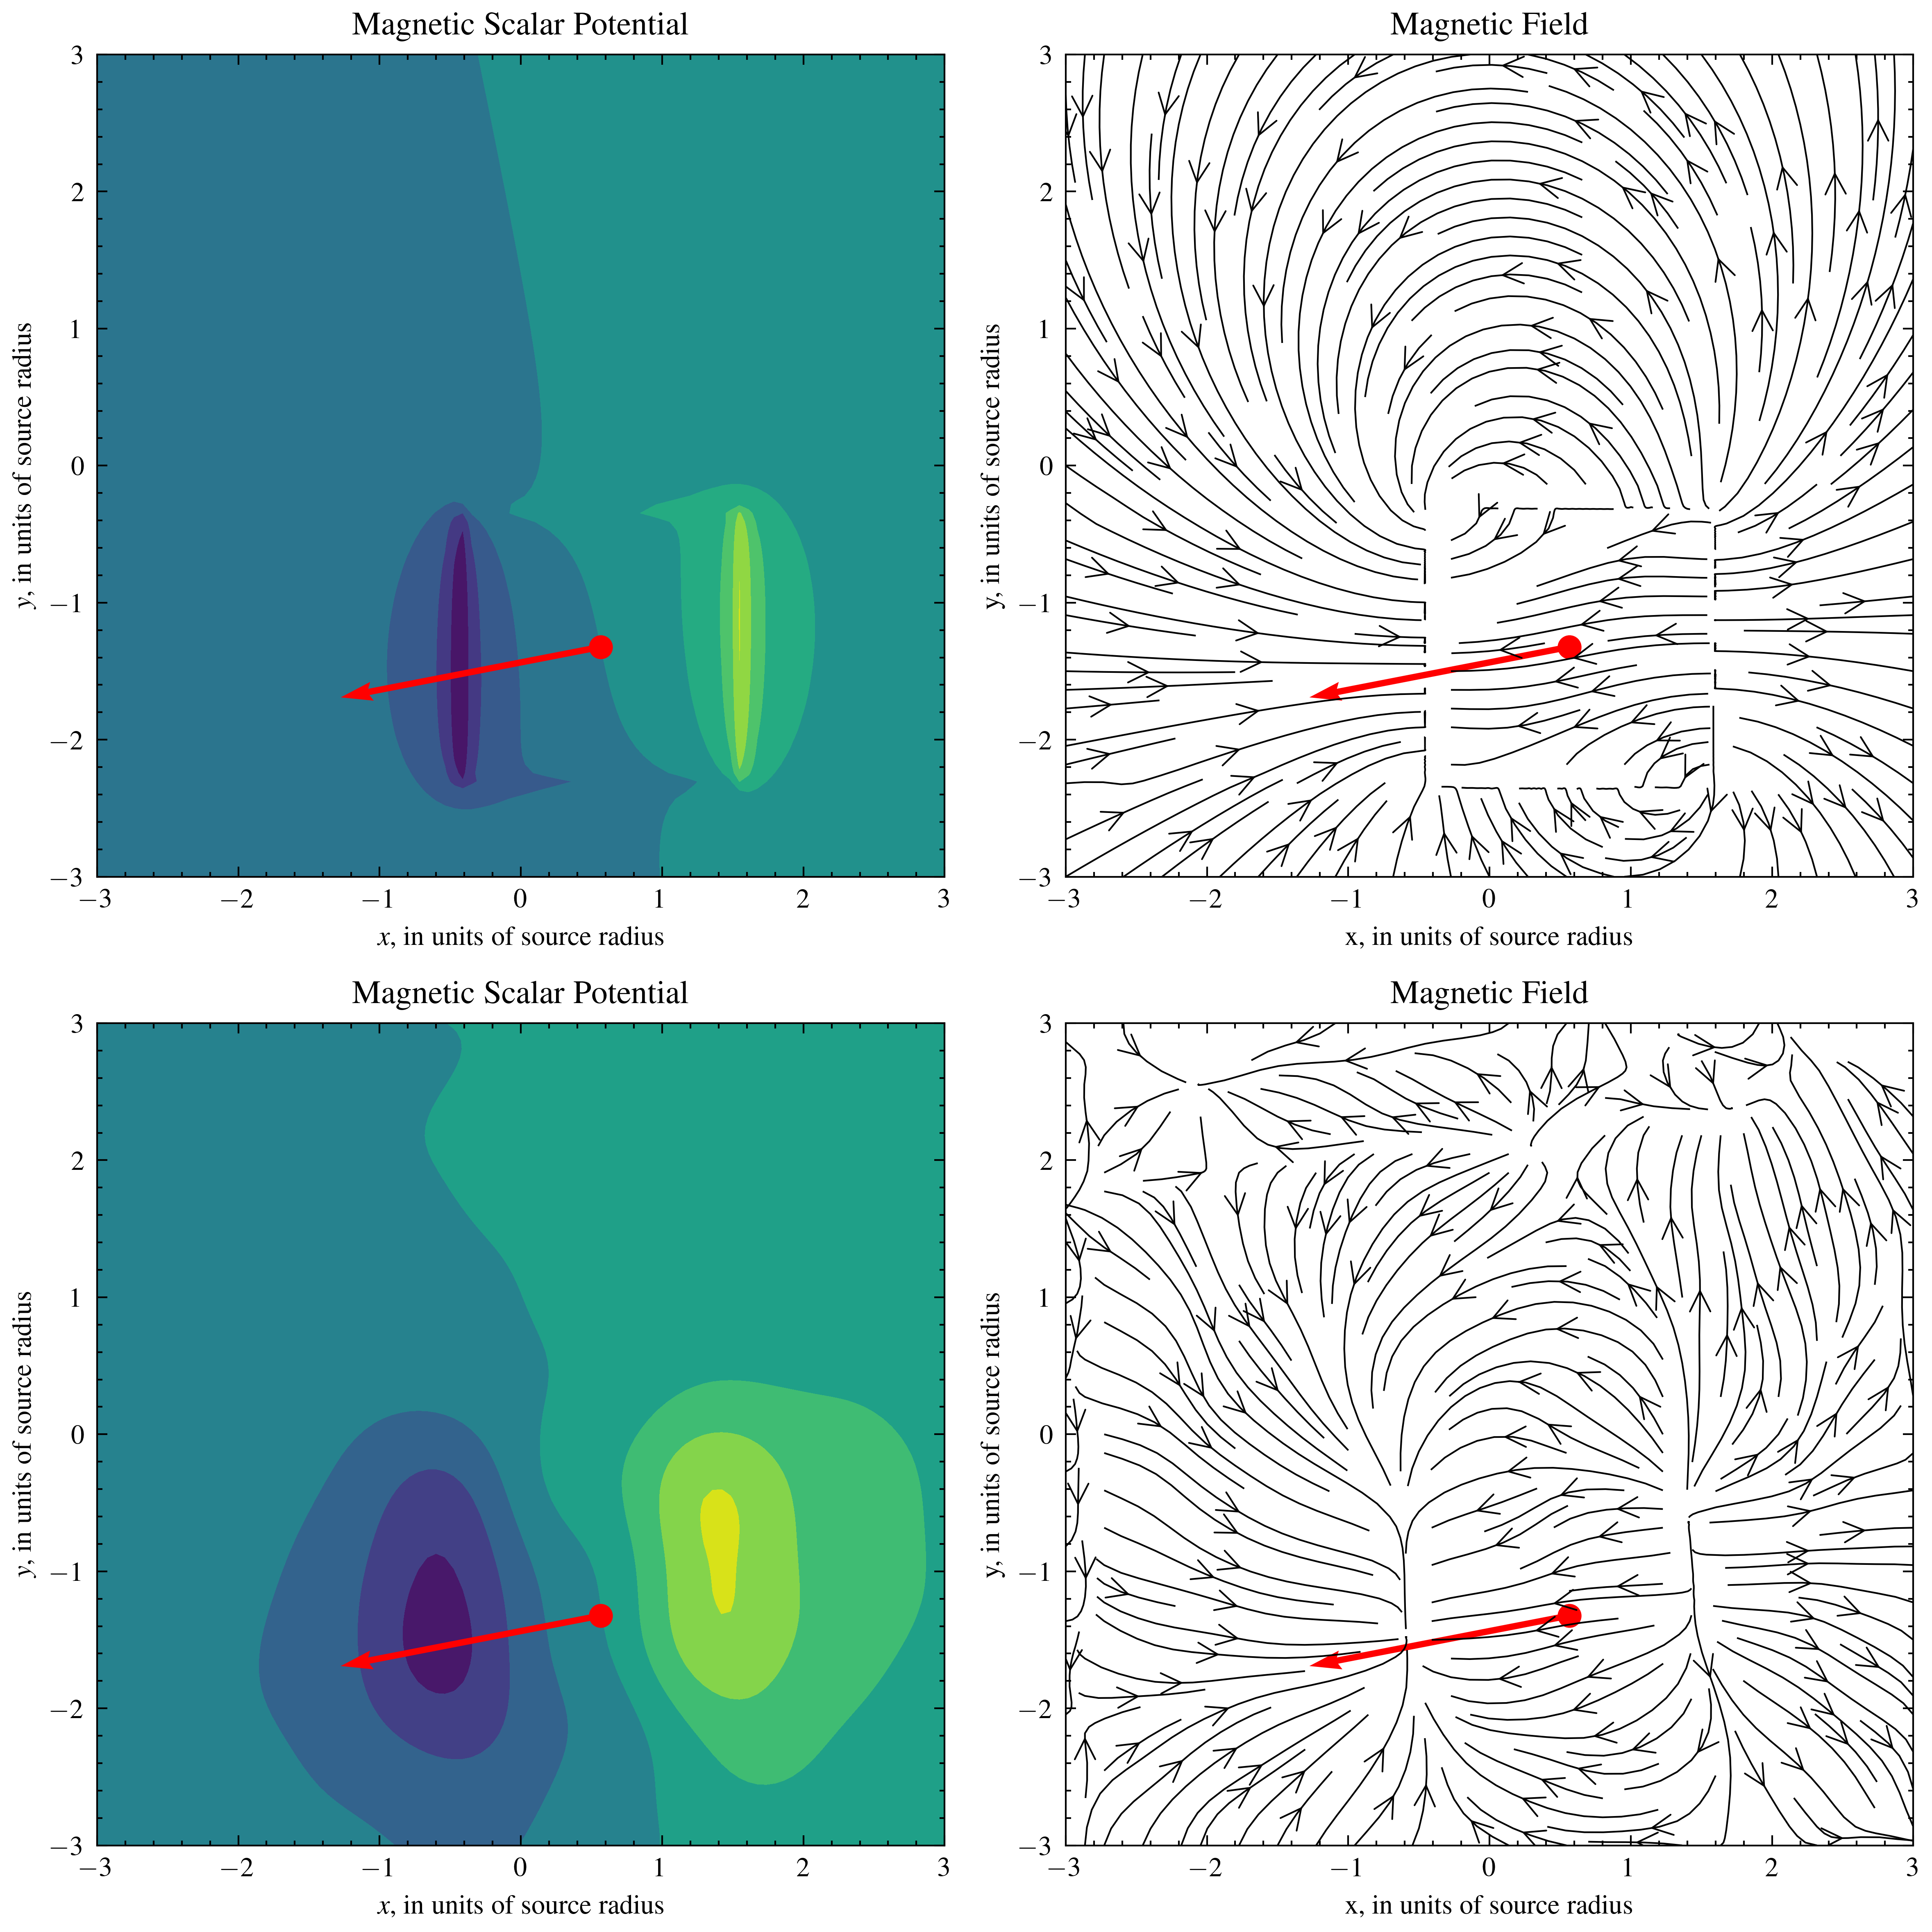

In [5]:
plots(train, model=model)